In [1]:
from urllib.request import urlopen
import datetime
from datetime import timedelta
import csv
import pandas as pd
from scipy import signal
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import numpy as np
import holidays
from datetime import timedelta
import math
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import os
from sklearn.metrics import mean_absolute_error

# In this notebook we dive a little deeper into model metrics to assess whether underlying assumptions of our linear model are being met

In [2]:
#pick which market model you want to analyze
os.chdir('C:\\Users\\teek2\\Documents\\Farmers Market Forecast\\Model_Files')
market_files=['SUN_AG_AWS.pkl','WED_AG_AWS.pkl','SUN_Hot Food_AWS.pkl','SUN_Retail_AWS.pkl','SUN_Coffee_AWS.pkl','SUN_Baked Goods_AWS.pkl']
sample_files=pd.read_pickle(market_files[0])

#calculate residuals
resids=list(sample_files.iloc[0]['model predictions']-sample_files.iloc[0]['actual sales'])

In [3]:
#this is the number of test points in the data set (set equal to value in modelBuild file)

test_length=50


#extract features and scale them 

#we will fit a model to the residuals now instead of the sales
feature_matrix=sample_files.iloc[0]['feature matrix']
contin_feat=sample_files.iloc[0]['continuous features']
bin_feat=sample_files.iloc[0]['binary features']
X_train=feature_matrix[:-test_length+1]
y_train=resids[:-test_length+1]
scaler=preprocessing.StandardScaler().fit(X_train[contin_feat])
X_train_scaled=np.concatenate((scaler.transform(X_train[contin_feat]),np.array(X_train[bin_feat])),axis=1)

X_test=feature_matrix[-test_length:]
y_test=resids[-test_length:]

X_test_scaled=np.concatenate((scaler.transform(X_test[contin_feat]),np.array(X_test[bin_feat])),axis=1)

# First let's try to train a model on our residuals to see if they are correlated with any of our features

In [36]:
#fit model to residuals and optimize params
param_grid = [
  {'alpha': [.1, 1,5, 10,50, 100, 250, 500,750,1000]}]

ridge=Ridge()
ridge_regressor=GridSearchCV(ridge,param_grid,scoring='neg_mean_absolute_error',cv=10)
ridge_regressor.fit(X_train_scaled,y_train)
reg_param=ridge_regressor.best_params_['alpha']
ridge=Ridge(alpha=reg_param)
ridge.fit(X_train_scaled,y_train)

Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

# Create coefficient table

In [37]:
resid_feats=sorted(list(zip(contin_feat+bin_feat,ridge.coef_)),key=lambda x:abs(x[1]),reverse=True)
#see which features were strongest predictors of residual values
pd.DataFrame({'Features':[x[0] for x in resid_feats],'Resid. model coeff.':[x[1] for x in resid_feats]})

Features  Resid. model coeff.
0       Thanksgiving             0.091245
1       Is_September             0.084858
2        Is_December             0.082246
3             Is_May            -0.061989
4         Is_October             0.060039
5   Previous Markets            -0.057957
6        July Fourth             0.057574
7            Is_July            -0.053403
8           Wash Day             0.048548
9          Labor Day            -0.038361
10         Christmas             0.034277
11               NYE             0.030163
12           Is_June            -0.029660
13               MLK            -0.027330
14          Is_April            -0.026724
15            Is_Feb            -0.024295
16         Is_August            -0.020323
17       Is_November             0.017930
18            Is_Jan            -0.015057
19          Is_March            -0.013621
20        Fire Index             0.010970
21          FM Index             0.010276
22  Previous Parking            -0.009546
23      Veterans Day             0.008332
24       Temperature            -0.008228
25        Superbowls             0.004246
26              Rain             0.004048
27       Time Offset            -0.002383
28              Wind             0.001939
29      Memorial Day            -0.000678
30       Num Vendors             0.000000

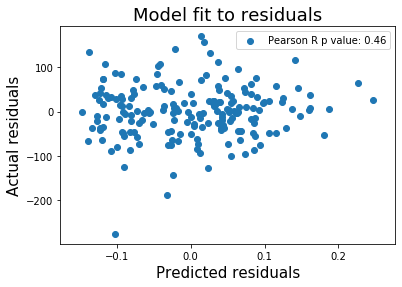

In [38]:
#plot the model predictions versus the actual residuals for training set

plt.figure()

pearson_val=pearsonr(ridge.predict(X_train_scaled),y_train)
z = np.polyfit(ridge.predict(X_train_scaled), y_train, 1)
plt.scatter(ridge.predict(X_train_scaled),y_train,label="Pearson R p value: {0:.2f}".format(pearson_val[1]))
plt.xlabel('Predicted residuals',fontsize=15)
plt.ylabel('Actual residuals',fontsize=15)
plt.title('Model fit to residuals',fontsize=18)
plt.legend()
#plt.savefig('Fit_2_resids_train.png',dpi=600)

In [107]:
#fit model to residuals and optimize params

ridge=Ridge()
ridge_regressor=GridSearchCV(ridge,param_grid,scoring='neg_mean_absolute_error',cv=10)
ridge_regressor.fit(X_test_scaled,y_test)
reg_param=ridge_regressor.best_params_['alpha']
ridge=Ridge(alpha=reg_param)
ridge.fit(X_test_scaled,y_test)

Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

# Let's apply the residual model to the test set

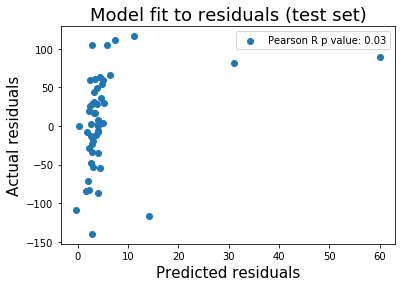

In [132]:
#now we can repeat for the test set

plt.figure()

pearson_val=pearsonr(ridge.predict(X_test_scaled),y_test)
z = np.polyfit(ridge.predict(X_test_scaled), y_test, 1)
plt.scatter(ridge.predict(X_test_scaled),y_test,label="Pearson R p value: {0:.2f}".format(pearson_val[1]))
plt.xlabel('Predicted residuals',fontsize=15)
plt.ylabel('Actual residuals',fontsize=15)
plt.title('Model fit to residuals (test set)',fontsize=18)
plt.legend()
plt.savefig('Fit_2_resids_test.png',dpi=600)

In [133]:
#see which features were strongest predictors of residual values
resid_feats=sorted(list(zip(contin_feat+bin_feat,ridge.coef_)),key=lambda x:abs(x[1]),reverse=True)
pd.DataFrame({'Features':[x[0] for x in resid_feats],'Resid. model coeff.':[x[1] for x in resid_feats]})

import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(header=dict(values=['A Scores', 'B Scores']),
                 cells=dict(values=[[x[0] for x in resid_feats], [x[1] for x in resid_feats]]))
                     ])
fig.show()

# To test for problematic correlations between feature values and residuals in our test set, we can calculate the Pearon R coefficients

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


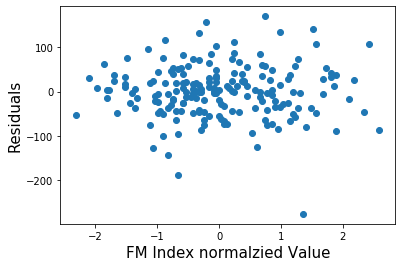

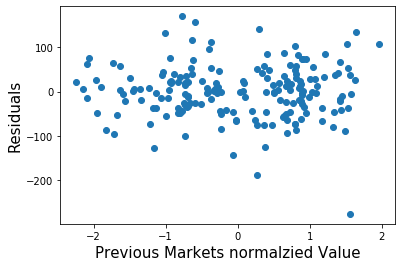

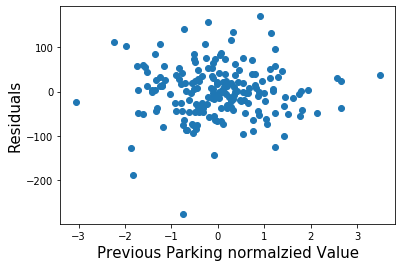

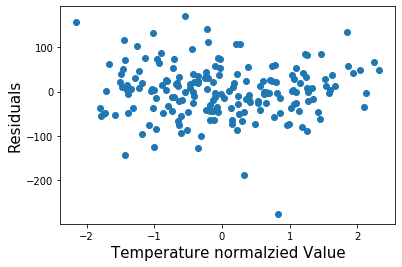

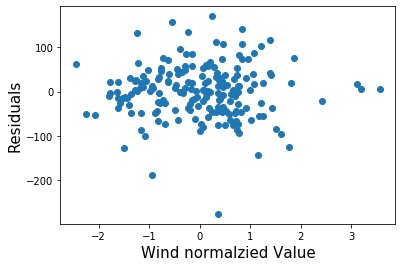

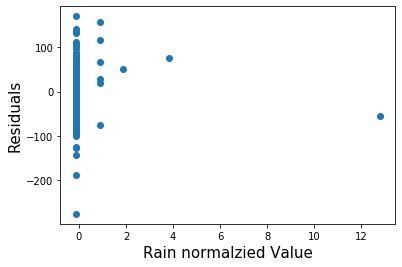

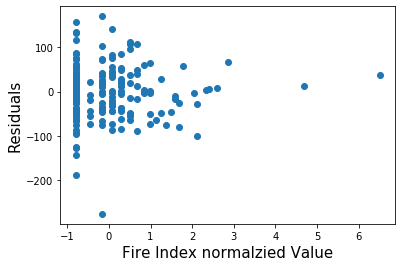

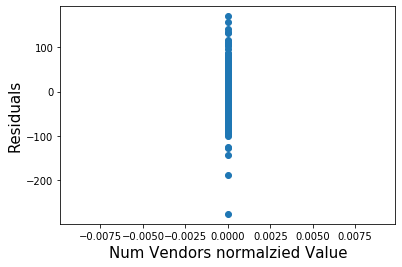

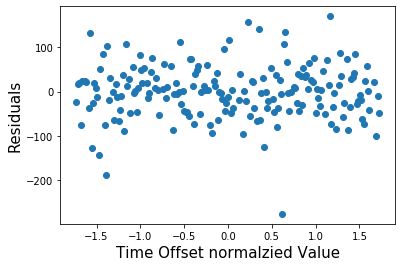

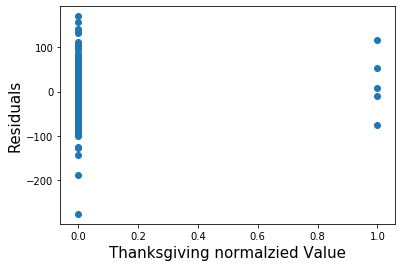

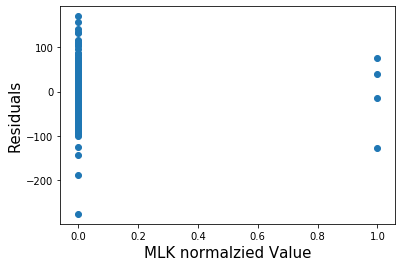

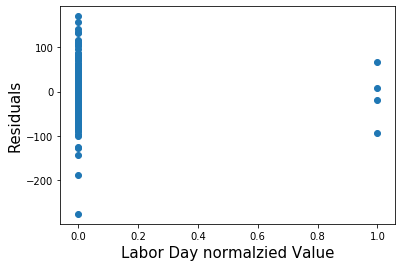

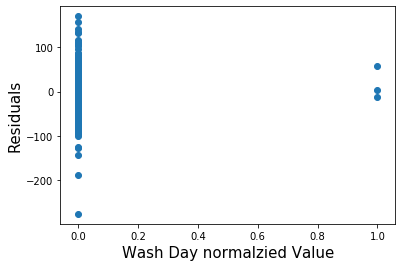

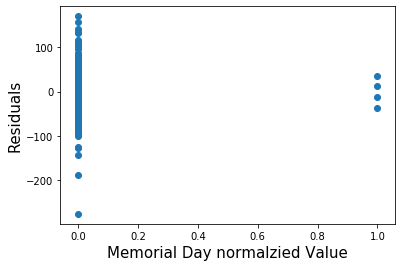

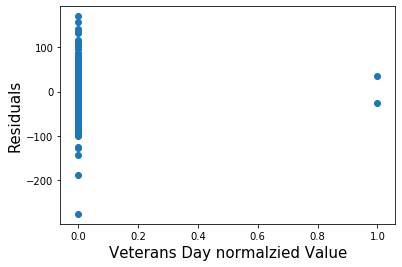

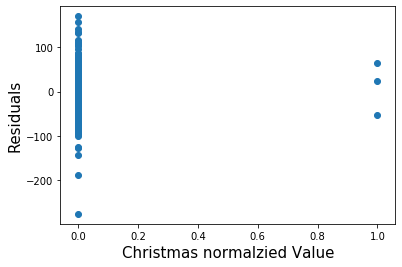

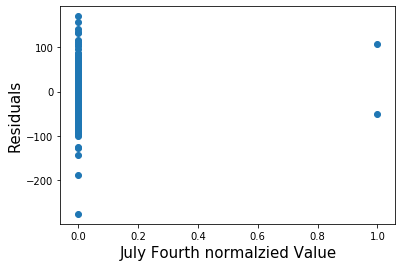

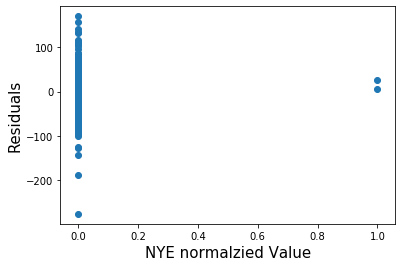

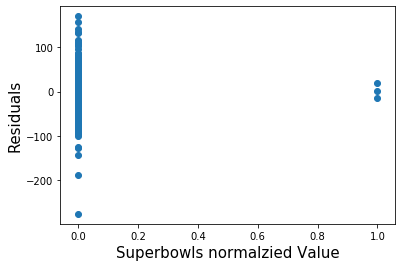

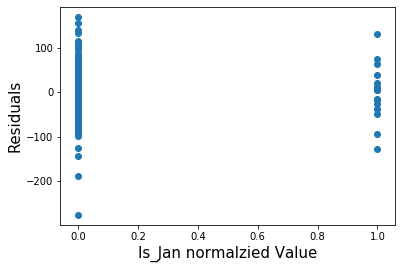

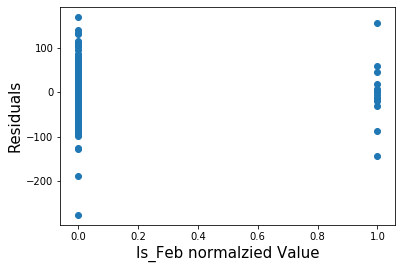

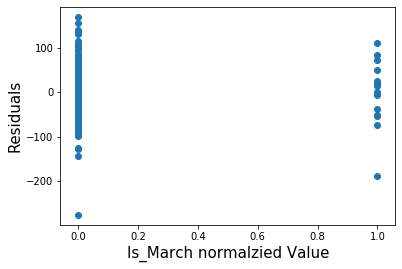

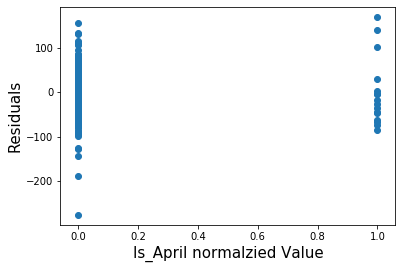

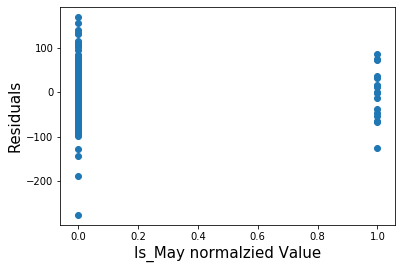

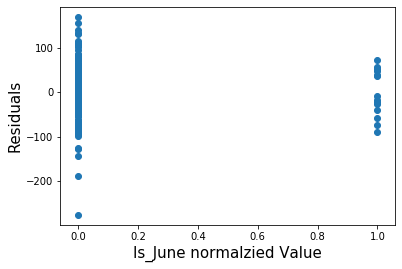

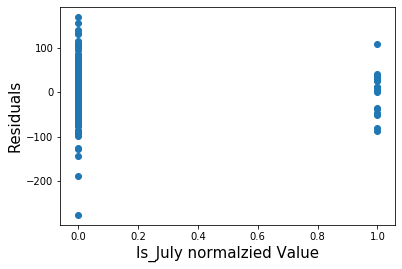

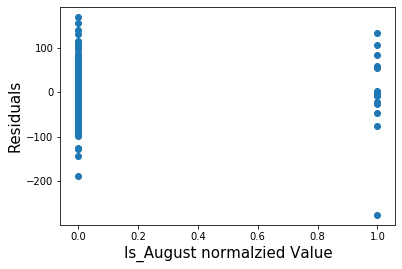

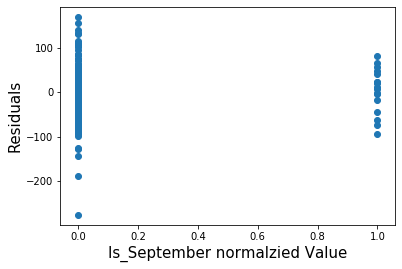

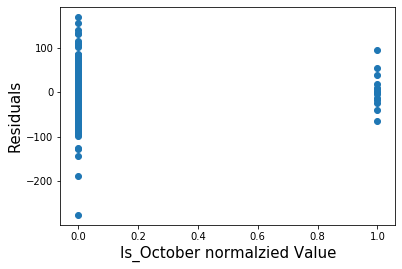

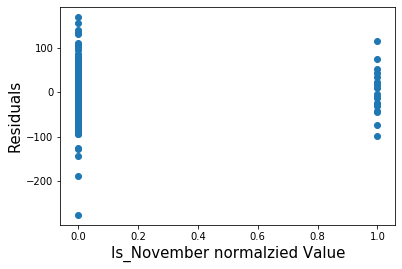

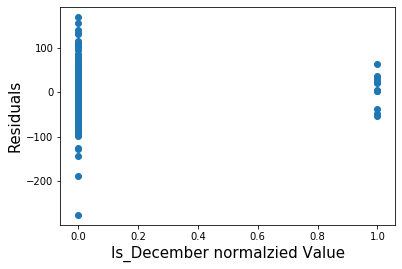

In [128]:
#calculate pearson r with each feature and the residuals
#first we are going to do this for the training data and then we will switch over to the test data later

#plot results
from scipy.stats import pearsonr
p_vals_resids=[]

for i in range(len(X_train_scaled[0])):
    current_feat=(contin_feat+bin_feat)[i]
    feature_vals=[item[i] for item in X_train_scaled]
    plt.figure()
    plt.scatter(feature_vals,y_train)
    plt.ylabel('Residuals',fontsize=15)
    plt.xlabel('{} normalzied Value'.format((contin_feat+bin_feat)[i]),fontsize=15)
    #plt.title('Residuals vs. {}'.format((contin_feat+bin_feat)[i]))
    pearson_val=pearsonr(y_train,feature_vals)
    p_vals_resids.append((current_feat,pearson_val[1]))
    if i==1:
        plt.savefig('PreviosMarkets_Residus.png',dpi=600)
        
        
    

# Let's examine these coefficients in both the training and test set (not accounting for multiple testing at the moment)

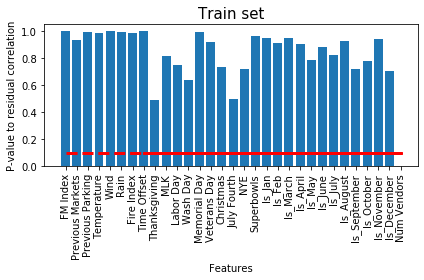

In [111]:
plt.figure()

feature_labels=[i[0] for i in p_vals_resids]
feature_vals=[i[1] for i in p_vals_resids]
numVendInd=feature_labels.index('Num Vendors')
del feature_labels[numVendInd]
del feature_vals[numVendInd]
plt.bar(feature_labels,feature_vals)
plt.ylabel('P-value to residual correlation')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.plot([i[0] for i in p_vals_resids],[.1]*len(p_vals_resids),linestyle='--',color='r',linewidth=3)
plt.title('Train set',fontsize=15)
plt.tight_layout()

os.chdir('C:\\Users\\teek2\\Documents\\Farmers Market Forecast\\Plots\\Residuals')
plt.savefig('feature_pvals_train.png')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


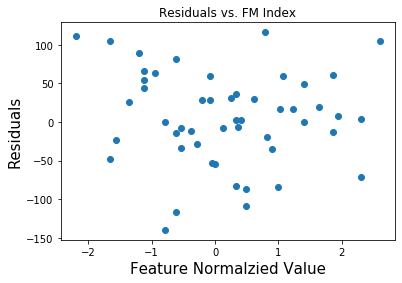

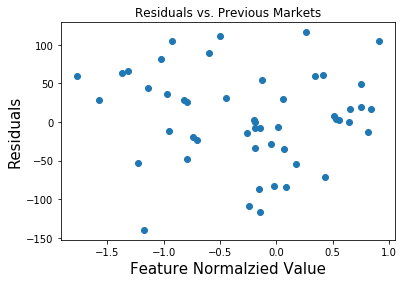

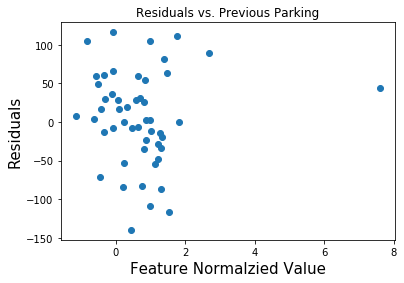

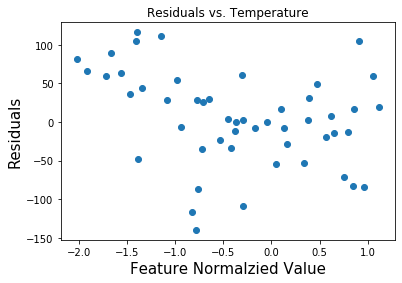

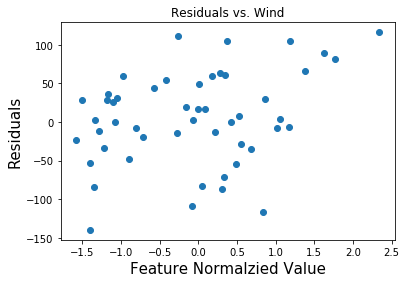

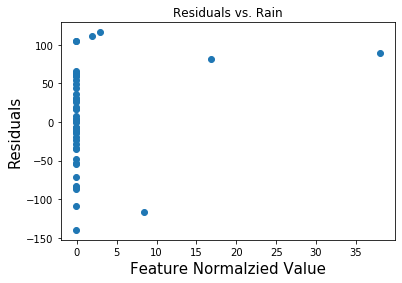

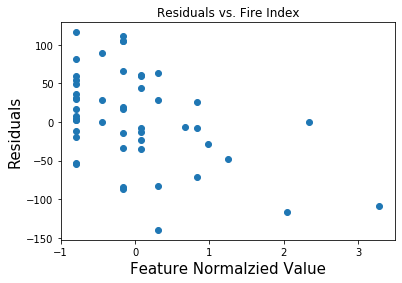

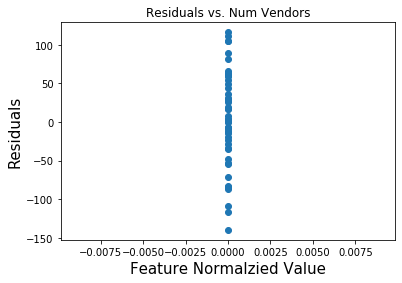

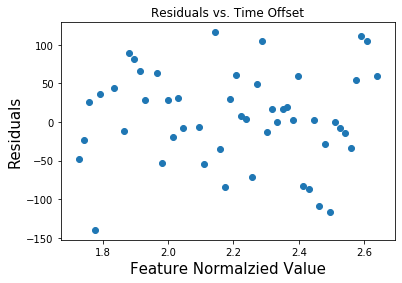

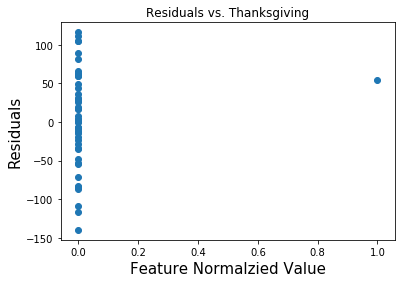

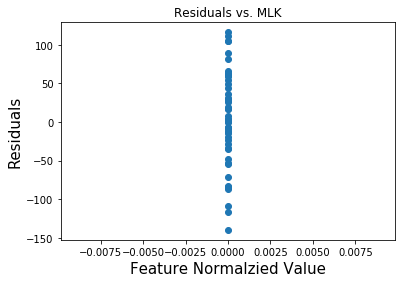

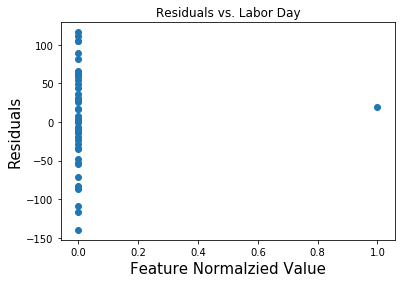

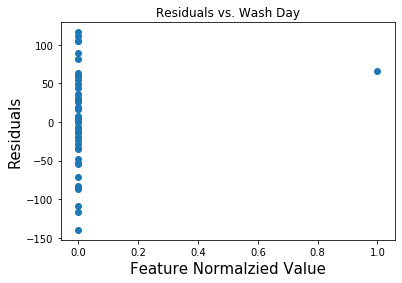

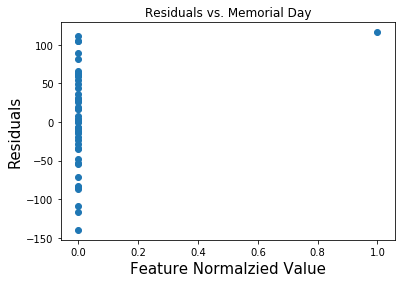

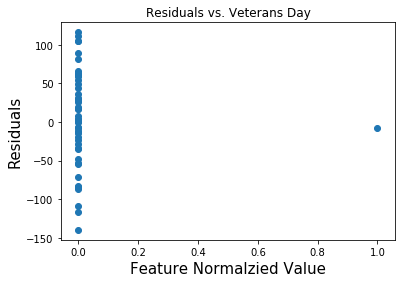

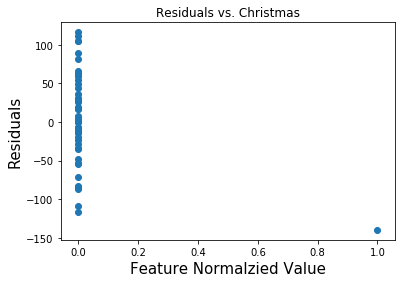

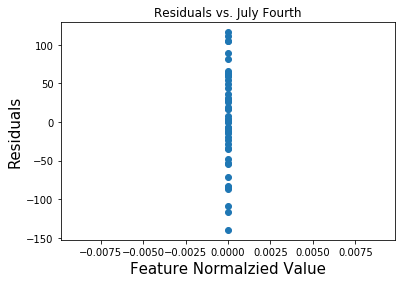

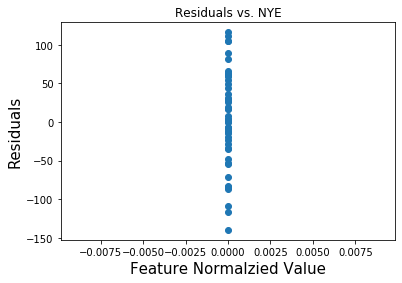

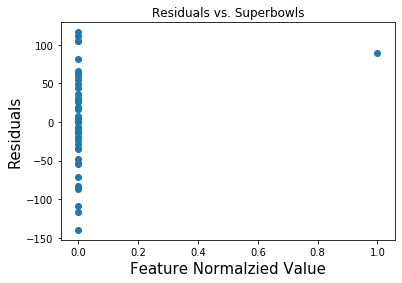

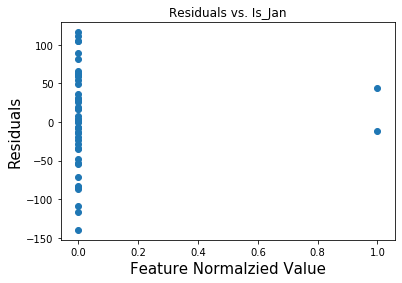

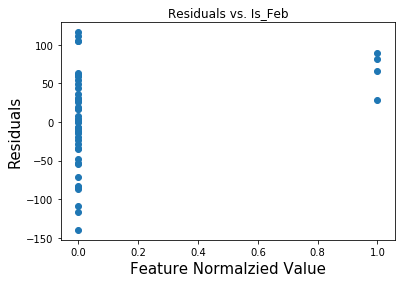

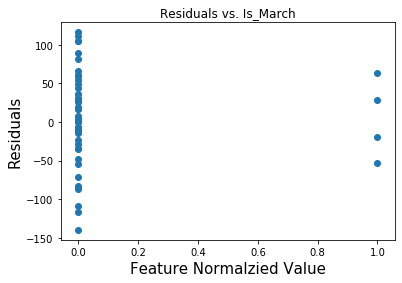

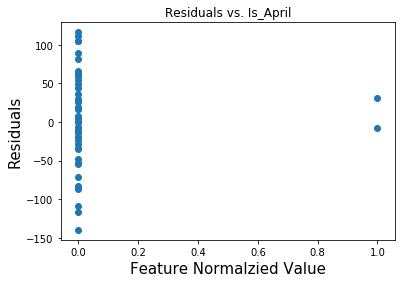

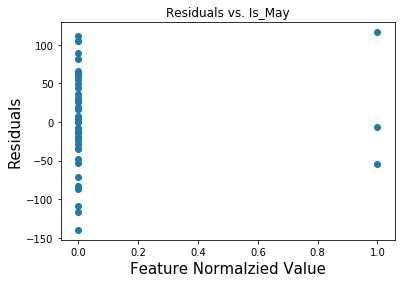

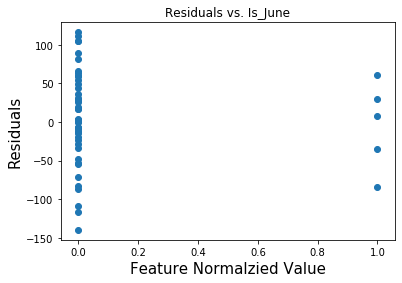

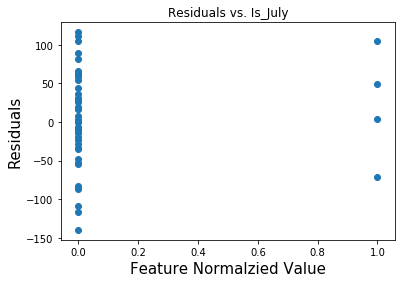

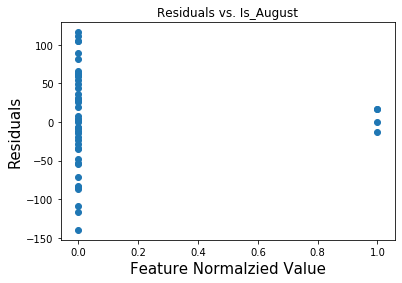

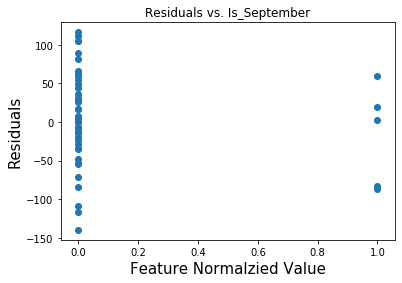

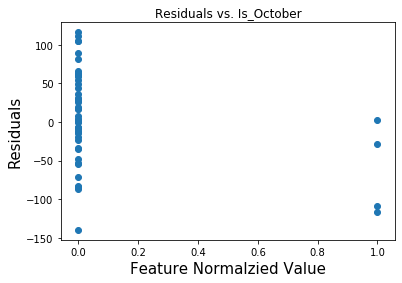

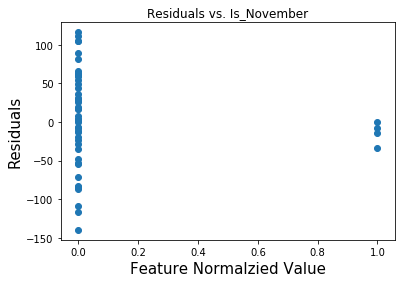

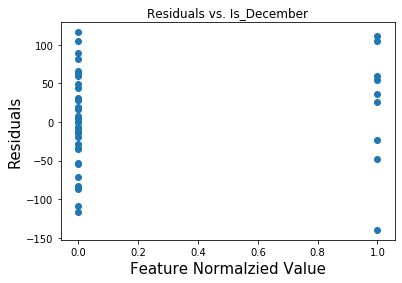

In [112]:
#calculate pearson r with each feature and the residuals

#plot results
p_vals_resids=[]


for i in range(len(X_test_scaled[0])):
    current_feat=(contin_feat+bin_feat)[i]
    feature_vals=[item[i] for item in X_test_scaled]
    plt.figure()
    plt.scatter(feature_vals,y_test)
    plt.ylabel('Residuals',fontsize=15)
    plt.xlabel('Feature Normalzied Value',fontsize=15)
    plt.title('Residuals vs. {}'.format((contin_feat+bin_feat)[i]))
    pearson_val=pearsonr(y_test,feature_vals)
    p_vals_resids.append((current_feat,pearson_val[1]))
    #if i==0:
        #plt.savefig('PreviosMarkets_Residus.png',dpi=600)
    

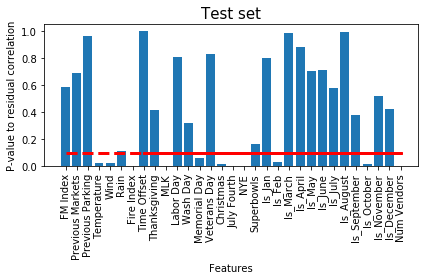

In [113]:
plt.figure()

feature_labels=[i[0] for i in p_vals_resids]
feature_vals=[i[1] for i in p_vals_resids]
numVendInd=feature_labels.index('Num Vendors')
del feature_labels[numVendInd]
del feature_vals[numVendInd]
plt.bar(feature_labels,feature_vals)
plt.ylabel('P-value to residual correlation')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.plot([i[0] for i in p_vals_resids],[.1]*len(p_vals_resids),linestyle='--',color='r',linewidth=3)
plt.title('Test set',fontsize=15)
plt.tight_layout()
    
os.chdir('C:\\Users\\teek2\\Documents\\Farmers Market Forecast\\Plots\\Residuals')
plt.savefig('feature_pvals_test.png')

# Create histogram of residuals

Train std: $59.83994709743699
Train mean: $0.2549929956133206
Test std: 60.4675004469345
Test mean: 5.488515259525285


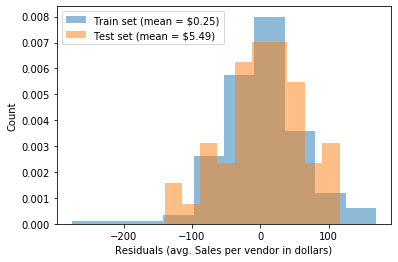

In [131]:
#show hist of residuals

import statistics as stats

print('Train std: ${}'.format(stats.stdev(resids[:-test_length])))
print('Train mean: ${}'.format(np.mean(resids[:-test_length])))
plt.figure()
plt.hist(resids[:-test_length],label='Train set (mean = ${0:.2f})'.format(np.mean(resids[:-test_length])),density=True,alpha=.5)
plt.xlabel('Residuals (Avg. Sales per Vendor, train set)')
plt.ylabel('Count')

print('Test std: {}'.format(stats.stdev(resids[-test_length:])))
print('Test mean: {}'.format(np.mean(resids[-test_length:])))
plt.hist(resids[-test_length:],label='Test set (mean = ${0:.2f})'.format(np.mean(resids[-test_length:])),density=True,alpha=.5)
plt.xlabel('Residuals (avg. Sales per vendor in dollars)')
plt.ylabel('Count')
plt.legend()
plt.savefig('residual_hist.png')

# Check for heteroskedasticity across time

Text(0.5, 0, 'Date')

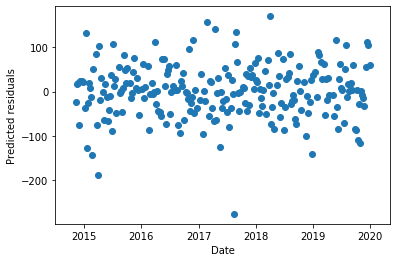

In [115]:
#plot residuals as a function of time

plt.figure()
plt.scatter(sample_files.iloc[0]['dates'],resids)
plt.ylabel('Predicted residuals')
plt.xlabel('Date')

# Check for autocorrealtion 

In [116]:
from pandas.plotting import autocorrelation_plot

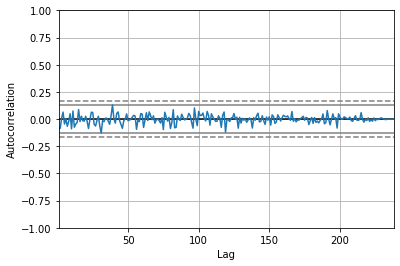

In [117]:
#construct autocorrelation plot

auto_plot=autocorrelation_plot(resids)
#auto_plot.get_figure().savefig('autocorrelation.png',dpi=600)

# Check for sales heteroskedasticity

(-0.5143155722469841, 4.367463216112619e-14)

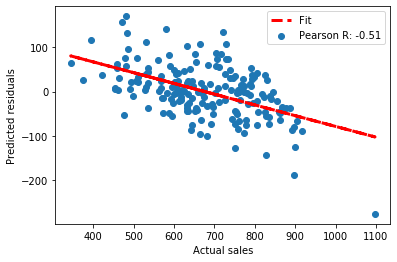

In [118]:
#Plot residual as a function of market sales

plt.figure()
z = np.polyfit(sample_files.iloc[0]['actual sales'][:-50], resids[:-50], 1)
plt.scatter(sample_files.iloc[0]['actual sales'][:-50],resids[:-50],label='Pearson R: -0.51')
plt.plot(sample_files.iloc[0]['actual sales'][:-50],z[0]*np.array(sample_files.iloc[0]['actual sales'][:-50])+z[1],color='r',linewidth=3,linestyle='--',label='Fit')
plt.ylabel('Predicted residuals')
plt.xlabel('Actual sales')
plt.legend()
#plt.savefig('heterodascity.png')
pearson_val=pearsonr(sample_files.iloc[0]['actual sales'][:-50],resids[:-50])
pearson_val

In [119]:
from statsmodels.graphics.gofplots import qqplot

# Generate QQ-Plot to test for normality of residuals

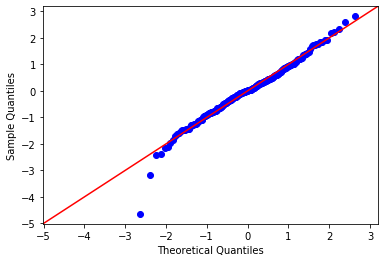

In [120]:
#qqplot for residuals

qplt=qqplot(np.array(resids),line='45',fit=True)
#qplt.get_figure().savegif('qqplot.png')

# Check for multi-colinearity via VIF's

In [121]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [122]:
vif_df=pd.DataFrame()
total_feat=contin_feat+bin_feat
vif=[variance_inflation_factor(np.array(X_train_scaled),i) for i in range(len(total_feat))]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [123]:
#calculate VIF factor for features
#helpful for mapping colinearities 

vif_df['features']=total_feat
vif_df['VIF']=vif
vif_df[vif_df['features']!='Num Vendors']

features       VIF
0           FM Index  5.698163
1   Previous Markets  5.948677
2   Previous Parking  1.929247
3        Temperature  3.122617
4               Wind  1.396638
5               Rain  1.205793
6         Fire Index  1.448327
8        Time Offset  1.745202
9       Thanksgiving  1.429585
10               MLK  1.415819
11         Labor Day  1.331902
12          Wash Day  1.408186
13      Memorial Day  1.355687
14      Veterans Day  1.207764
15         Christmas  1.301120
16       July Fourth  1.173646
17               NYE  1.271837
18        Superbowls  1.403067
19            Is_Jan  2.850485
20            Is_Feb  2.270374
21          Is_March  1.263844
22          Is_April  1.099338
23            Is_May  1.684354
24           Is_June  1.891245
25           Is_July  2.954538
26         Is_August  1.901861
27      Is_September  1.901828
28        Is_October  1.251411
29       Is_November  2.114976
30       Is_December  2.570565

In [124]:

import scipy
X_scaled=np.concatenate((scaler.transform(feature_matrix[contin_feat]),np.array(feature_matrix[bin_feat])),axis=1)
feat_nums=list(range(len(total_feat)))
feat_nums.remove(numVendInd)
vif_grid=[[variance_inflation_factor(X_scaled[:,[i,j]],1) for j in feat_nums] for i in feat_nums]
pearson_grid=[[scipy.stats.linregress(X_scaled[:,i],X_scaled[:,j])[2] for j in feat_nums] for i in feat_nums]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [125]:
from matplotlib.pyplot import pcolormesh

# Plot VIF's on pairwise grid

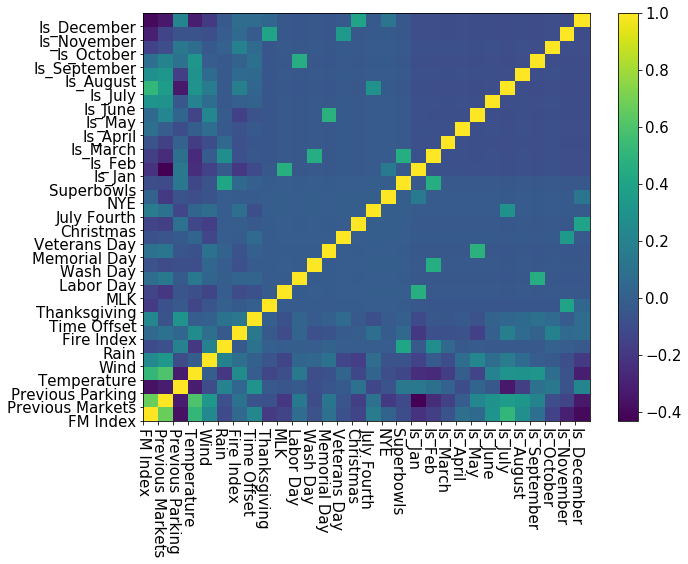

In [126]:
#make plot of correaltion between individuals pairs of features
#gives us another sense of where colinearities may be showing up

grid_labels=list(feature_matrix.columns)
grid_labels.remove('Num Vendors')
%matplotlib inline
fig, ax0 = plt.subplots(figsize=(10,7.5))

im = ax0.pcolormesh(pearson_grid)
cbar=fig.colorbar(im, ax=ax0)
cbar.ax.tick_params(labelsize=15)
ax0.set_xticklabels(grid_labels,fontsize=15)
ax0.set_yticklabels(grid_labels,fontsize=15)
plt.setp(ax0.get_xticklabels(), rotation=-90)
ax0.set_xticks(np.arange(len(vif_grid)))
ax0.set_yticks(np.arange(len(vif_grid)))
plt.show()
fig.tight_layout()

fig.savefig('correaltion_matrix.png',dpi=500)